# Title

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

### Frame the problem

How will Airbnb benefit from the model?

If we can ascertain the features that contribute to the "success" of a listing (represented by whether or not it receives reviews), we can direct marketing energy towards potential hosts who are more likely to succeed.

### Previous attempts at the problem



## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [110]:
# import libraries

from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from scipy import stats

In [2]:
airbnb = pd.read_csv('data/AB_NYC_2019.csv')

airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Missing values

In [3]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [4]:
airbnb = airbnb.drop(columns= ['id', 'name', 'host_id', 'host_name'])
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<AxesSubplot:ylabel='Density'>

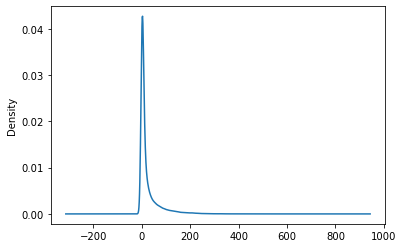

In [5]:
airbnb['number_of_reviews'].plot(kind = 'density')

Let's investigate these missing values for `last review` and `reviews_per_month`

In [6]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [7]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [9]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set **(CITE)**.


In [11]:
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.2)
raw_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
32645,Brooklyn,Williamsburg,40.71577,-73.95530,Entire home/apt,295,3,11,1,1
23615,Manhattan,Washington Heights,40.84917,-73.94048,Private room,70,2,2,1,0
31183,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,Private room,58,2,0,2,0
29260,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,Entire home/apt,75,3,87,1,267
7275,Queens,Woodside,40.74705,-73.89564,Private room,38,5,13,1,0


### Encode the Target Variable

In [43]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

eda_data = encode_target(raw_train)
X_train = eda_data.copy()
y_train = X_train.pop('has_reviews')
y_train.value_counts()

1    31010
0     8106
Name: has_reviews, dtype: int64

In [13]:
# repeat on the test set

X_test = encode_target(raw_test)
y_test = X_test.pop('has_reviews')

### EDA

Next, examine the distribution of numeric features.

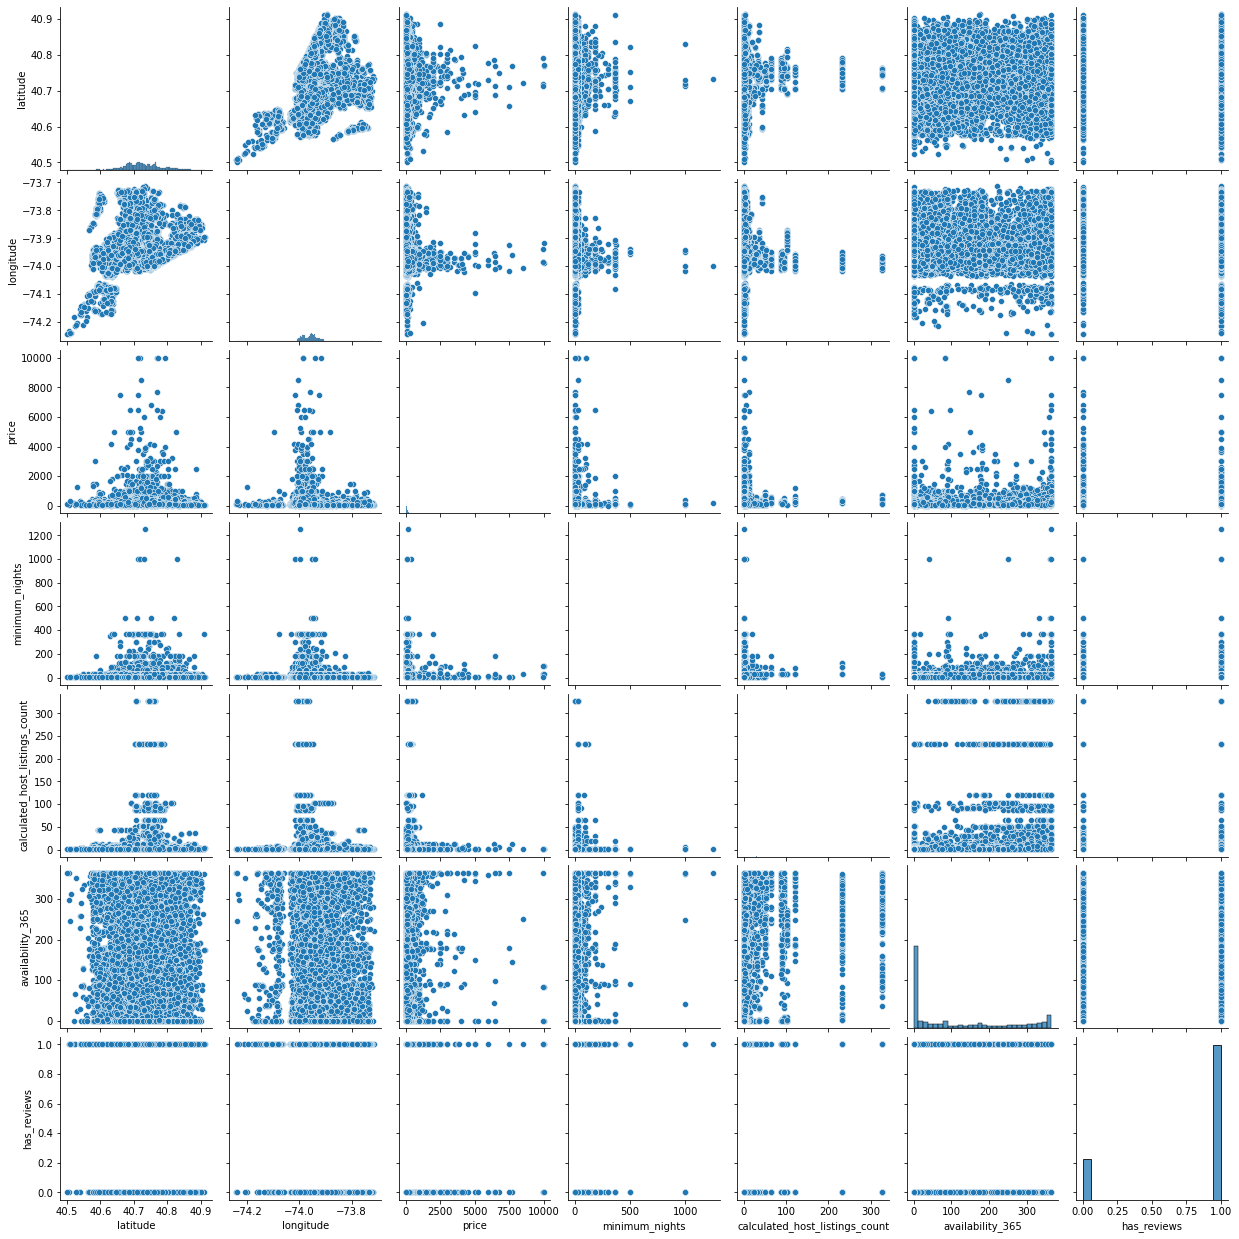

In [14]:
### Numerical attributes

numerical_data = eda_data.select_dtypes('number')
sns.pairplot(numerical_data);

**comment on this**

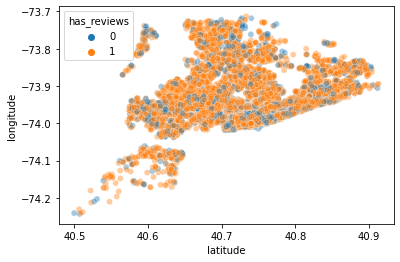

In [20]:
sns.scatterplot(data = eda_data, x = 'latitude', y = 'longitude', hue = 'has_reviews', alpha = 0.4);

In [33]:
def plot_distribution(df, col_of_interest, title = None):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    sns.kdeplot(data = df, x = col_of_interest, hue = 'has_reviews')
    sns.rugplot(data = df, x = col_of_interest, color = 'lightgray')
    plt.title(title);

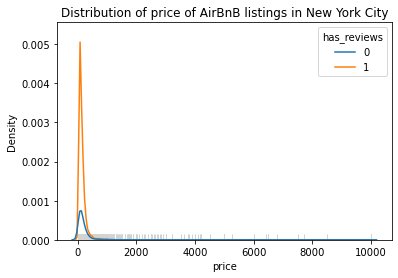

In [35]:
plot_distribution(eda_data, 'price')

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

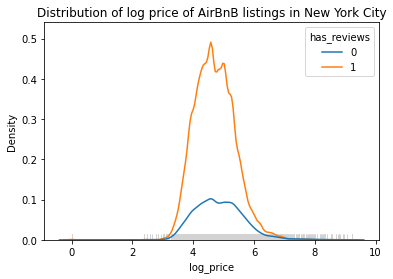

In [44]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price')

The natural logarithm of price is approximately normally distributed.

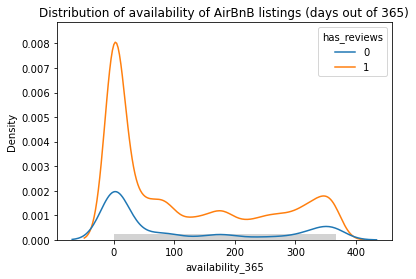

In [38]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [39]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,3882
1,10071


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable.

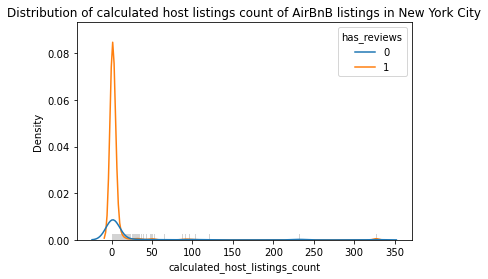

In [40]:
plot_distribution(eda_data, 'calculated_host_listings_count')

Again, this looks like a log normal distribution with some very large outliers.

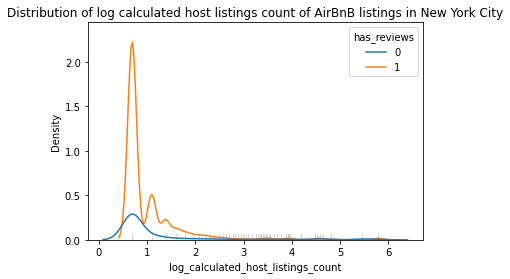

In [113]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str]) -> pd.DataFrame:
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'])
plot_distribution(eda_data, 'log_calculated_host_listings_count')

On inspection it does not appear to be a log normal distribution.

In [56]:
eda_data[eda_data['calculated_host_listings_count']>50].groupby('calculated_host_listings_count')['has_reviews'].value_counts()

calculated_host_listings_count  has_reviews
52                              1               80
                                0               11
65                              0               54
                                1                1
87                              0               37
                                1               35
91                              1               60
                                0               10
96                              0               81
                                1               71
103                             0               41
                                1               38
121                             0               61
                                1               30
232                             0              174
                                1               18
327                             1              170
                                0               95
Name: has_reviews, dtype: int64

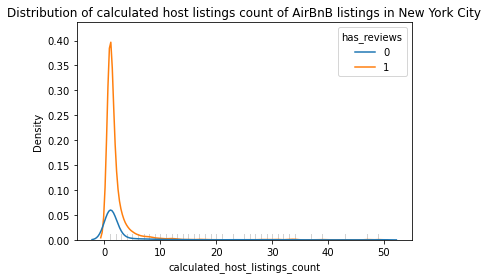

In [101]:
plot_distribution(eda_data[eda_data['calculated_host_listings_count']<50], 'calculated_host_listings_count')

Given how few listings belong to hosts with more than one listing, it might make more sense to replace with listing with a 0/1 option (1 or more listings). I will add this feature now to consider later.

In [102]:
eda_data['has_multiple_listings'] = eda_data['calculated_host_listings_count'].apply(lambda x: 0 if x==1 else 1)
count_listings_reviews = eda_data[['has_multiple_listings', 'has_reviews']].value_counts().reset_index()
count_listings_reviews.columns = ['has_multiple_listings', 'has_reviews', 'count']
count_listings_reviews

,has_multiple_listings,has_reviews,count
0,0,1,20224
1,1,1,10786
2,0,0,5610
3,1,0,2496


<AxesSubplot:xlabel='has_multiple_listings', ylabel='count'>

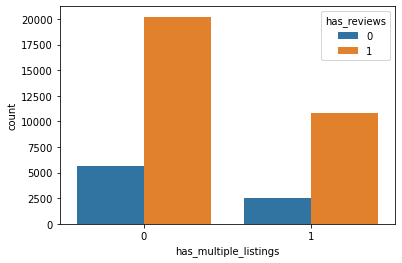

In [103]:
sns.barplot(data = count_listings_reviews, x = 'has_multiple_listings', y = 'count', hue = 'has_reviews')

On inspection it looks like there is more variation in `has_reviews` when the actual count of listings is used.

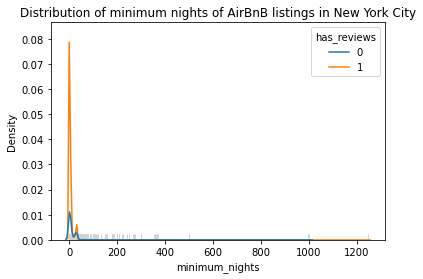

In [104]:
plot_distribution(eda_data, 'minimum_nights')

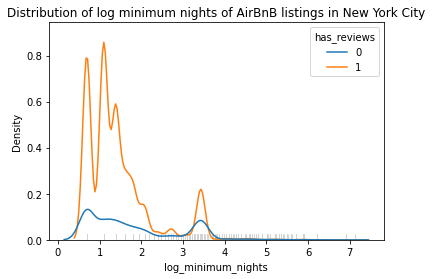

In [114]:
eda_data = transform_log_normal_variables(eda_data, ['minimum_nights'])
plot_distribution(eda_data, 'log_minimum_nights')